In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
from scipy.spatial.distance import mahalanobis
import os
import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.unknown_truncation_normal import truncated_normal
from delphi.utils.constants import COSINE
from delphi.oracle import Left, Interval, Unknown_Gaussian
import datetime
# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Helpers

In [2]:
EXP_NAME = 'truncated_exp'
STORE_PATH = '/home/gridsan/stefanou/truncated/' + EXP_NAME
STORE_TABLE_NAME = 'logs'

## Default Experiment Parameters

In [3]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 1

# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'workers': 1, 
    'batch_size': 10,
    'bias': True,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'degree': 100, 
    'custom_lr_multiplier': COSINE,
})

In [4]:
# create new store
store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_kl': float,
    'naive_kl': float,
    'alpha': float, 
    'C': float,
})

# perform each experiment a total of 10 times
for iter_ in range(10): 
    for C in [.5, -1, -.5, 0, .5]:
        # truncation oracle
        PREDICATE = Left(Tensor([C]))
        # sample from a univariate gaussian distribution
        M =MultivariateNormal(ch.zeros(DIMS), ch.eye(DIMS))
        samples = M.sample(ch.Size([NUM_SAMPLES]))
        S = samples[PREDICATE(samples).nonzero(as_tuple=False).flatten()]
        args.__setattr__('alpha', Tensor([S.size(0) / NUM_SAMPLES]))
        args.__setattr__('phi', Unknown_Gaussian(S.mean(0), S.var(0).unsqueeze(0), S, args.degree))

        # truncated normal distribution
        truncated = truncated_normal(args.phi, args.alpha, args)
        results = truncated.fit(S)

        # metrics
        delphi_kl = ch.distributions.kl.kl_divergence(results, M)
        naive_kl = ch.distributions.kl.kl_divergence(MultivariateNormal(S.mean(0, S.dataset.var.unsqueeze(0)), M)

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_kl': delphi_kl,
            'naive_kl': naive_kl,
            'alpha': float(args.alpha),
            'C': C,
        })

# close current store
store.close()

Logging in: /home/gridsan/stefanou/truncated/truncated_exp/2678b326-52fd-4e97-8d57-4ad0991f5be6
==> Preparing dataset truncated_normal..


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/315 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'dataset'

# Results

In [23]:
reader = CollectionReader(STORE_PATH)
df = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
df.head()

100%|██████████| 1/1 [00:00<00:00, 129.41it/s]


,delphi_kl,naive_kl,alpha,C,exp_id
0,0.414138,0.922270,0.3155,0.5,4192cfe2-2f73-4cb9-b458-8596be521fb3
1,0.046498,0.089627,0.8376,-1.0,4192cfe2-2f73-4cb9-b458-8596be521fb3
2,0.102729,0.229948,0.6853,-0.5,4192cfe2-2f73-4cb9-b458-8596be521fb3
3,0.249249,0.512148,0.4933,0.0,4192cfe2-2f73-4cb9-b458-8596be521fb3
4,0.547109,0.949433,0.3143,0.5,4192cfe2-2f73-4cb9-b458-8596be521fb3


# All Trials

all trials:


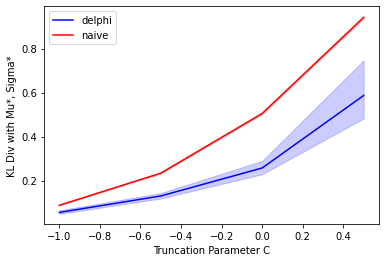

In [24]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=df, x='C', y='delphi_kl', label='delphi', color='blue')
ax = sns.lineplot(data=df, x='C', y='naive_kl', label='naive', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='KL Div with Mu*, Sigma*')
plt.show()

(array([485., 454., 387., 349., 286., 232., 200., 152., 136.,  80.,  65.,
         48.,  44.,  41.,  20.,  16.,  14.,   5.,   3.,   3.,   0.,   0.,
          2.,   1.,   1.]),
 array([0.5003123 , 0.64361125, 0.7869102 , 0.9302091 , 1.073508  ,
        1.216807  , 1.3601059 , 1.5034049 , 1.6467037 , 1.7900027 ,
        1.9333017 , 2.0766006 , 2.2198994 , 2.3631985 , 2.5064974 ,
        2.6497962 , 2.793095  , 2.9363942 , 3.079693  , 3.222992  ,
        3.366291  , 3.50959   , 3.6528888 , 3.7961876 , 3.9394867 ,
        4.0827856 ], dtype=float32),
 <a list of 25 Patch objects>)

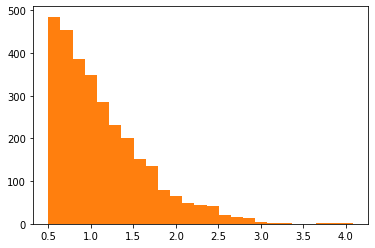

In [21]:
plt.hist(samples[samples > .5].T, bins=25)
plt.hist(S.dataset.S.T, bins=25)

In [31]:
results

MultivariateNormal(loc: tensor([0.6659], requires_grad=True), covariance_matrix: tensor([[0.9364]], requires_grad=True))

In [19]:
S.dataset.S.size()

torch.Size([3024, 1])